#Data Preparation

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
behrad3d_nasa_cmaps_path = kagglehub.dataset_download('behrad3d/nasa-cmaps')
print('Data source import complete.')

# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define column names based on the dataset structure
columns = ['engine_id', 'cycle', 'setting_1', 'setting_2', 'setting_3'] + \
          ['sensor_' + str(i) for i in range(1, 22)]

# Load the training data from the specified path
# We use os.path.join to build a correct file path
# The data is space-separated, so sep=r'\s+' is used.
data_path = os.path.join(behrad3d_nasa_cmaps_path, 'CMaps', 'train_FD001.txt')
train_df = pd.read_csv(data_path, sep=r'\s+', header=None, names=columns)

# Display the first few rows to verify correct loading
train_df.head()

100%|██████████| 12.3M/12.3M [00:00<00:00, 105MB/s]

Extracting files...


Data source import complete.


,engine_id,cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


##Data Cleaning and Preprocessing

In [2]:
# Check for any missing values across the dataset
missing_values_count = train_df.isnull().sum().sum()
print(f"Total missing values: {missing_values_count}")

# Identify and remove columns with constant values
# These columns provide no predictive power
constant_cols = [col for col in train_df.columns if train_df[col].nunique() <= 1]
train_df.drop(columns=constant_cols, inplace=True)

# Display the remaining columns after cleanup
print("\nRemaining columns after removing non-informative features:")
print(train_df.columns)

Total missing values: 0

Remaining columns after removing non-informative features:
Index(['engine_id', 'cycle', 'setting_1', 'setting_2', 'sensor_2', 'sensor_3',
       'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17',
       'sensor_20', 'sensor_21'],
      dtype='object')


#EDA + Feature Building


We will transform the raw data into meaningful features for our model.


*  Remaining Useful Life (RUL): We'll calculate the number of cycles an engine has left before it fails.

*  Target Label: We'll create a binary label to indicate if an engine is at high risk of failure (e.g., within 30 cycles).

*   Rolling Statistics: We'll calculate rolling mean and standard deviation for sensor readings to capture trends over time.





In [3]:
# Calculate Remaining Useful Life (RUL)
# This is the number of cycles from the current point until the engine's last recorded cycle
rul_per_engine = train_df.groupby('engine_id')['cycle'].max()
train_df['RUL'] = train_df['engine_id'].map(rul_per_engine) - train_df['cycle']

# Create the binary target label
# A label of 1 indicates high risk of failure (RUL <= 30 cycles)
threshold = 30
train_df['label'] = train_df['RUL'].apply(lambda x: 1 if x <= threshold else 0)

# Create rolling mean and standard deviation features for all sensor readings
# A window of 10 cycles is used to capture recent trends
features_to_engineer = [col for col in train_df.columns if 'sensor' in col]
for feature in features_to_engineer:
    train_df[f'rolling_mean_{feature}_10'] = train_df.groupby('engine_id')[feature].rolling(window=10).mean().reset_index(level=0, drop=True)
    train_df[f'rolling_std_{feature}_10'] = train_df.groupby('engine_id')[feature].rolling(window=10).std().reset_index(level=0, drop=True)

# Remove the rows with NaN values that resulted from the rolling calculations
train_df.dropna(inplace=True)

# Display the processed data with new features
train_df.head()

,engine_id,cycle,setting_1,setting_2,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,...,rolling_mean_sensor_14_10,rolling_std_sensor_14_10,rolling_mean_sensor_15_10,rolling_std_sensor_15_10,rolling_mean_sensor_17_10,rolling_std_sensor_17_10,rolling_mean_sensor_20_10,rolling_std_sensor_20_10,rolling_mean_sensor_21_10,rolling_std_sensor_21_10
9,1,10,-0.0033,0.0001,641.71,1591.24,1400.46,21.61,553.59,2388.05,...,8132.228,3.333946,8.40839,0.022654,391.8,0.918937,38.984,0.070111,23.38960,0.044857
10,1,11,0.0018,-0.0003,642.28,1581.75,1400.64,21.61,554.54,2388.05,...,8132.424,3.779342,8.40984,0.023876,391.8,0.918937,38.972,0.065794,23.39557,0.052522
11,1,12,0.0016,0.0002,642.06,1583.41,1400.15,21.61,554.52,2388.09,...,8132.700,3.804252,8.40604,0.023000,391.7,0.948683,38.978,0.071149,23.38981,0.052264
12,1,13,-0.0019,0.0004,643.07,1582.19,1400.83,21.61,553.44,2388.12,...,8132.187,4.061997,8.40578,0.022867,392.0,0.816497,38.976,0.072296,23.38296,0.062411
13,1,14,0.0009,-0.0000,642.35,1592.95,1399.16,21.61,554.48,2388.09,...,8132.247,4.093274,8.40860,0.019155,392.1,0.875595,39.006,0.088468,23.38383,0.062331


#Model Training & Validation


##Data Splitting

We need to split our dataset into a training set and a validation set. The model will learn from the training data and be evaluated on the validation data to ensure it can generalize to new, unseen examples. We'll use an 80/20 split.

In [6]:
# Define features (X) and target (y)
# The 'engine_id', 'cycle', and 'RUL' columns are not used as features
features = [col for col in train_df.columns if 'sensor' in col or 'setting' in col]
X = train_df[features]
y = train_df['label']

# Split the data into training and validation sets
# `stratify=y` ensures the proportion of high-risk cases is the same in both sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (15784, 47)
Validation set shape: (3947, 47)


##Training and Evaluation

We will train a Random Forest Classifier model. A key consideration for this project is the class imbalance
(far fewer failure cases than non-failure cases). We'll handle this by setting the `class_weight` parameter to `'balanced'`. After training, we will evaluate the model's performance using standard metrics.

Model Evaluation on Validation Set:
Accuracy: 0.9693

Classification Report:
              precision    recall  f1-score   support

  No-Failure       0.97      0.99      0.98      3327
     Failure       0.95      0.85      0.90       620

    accuracy                           0.97      3947
   macro avg       0.96      0.92      0.94      3947
weighted avg       0.97      0.97      0.97      3947



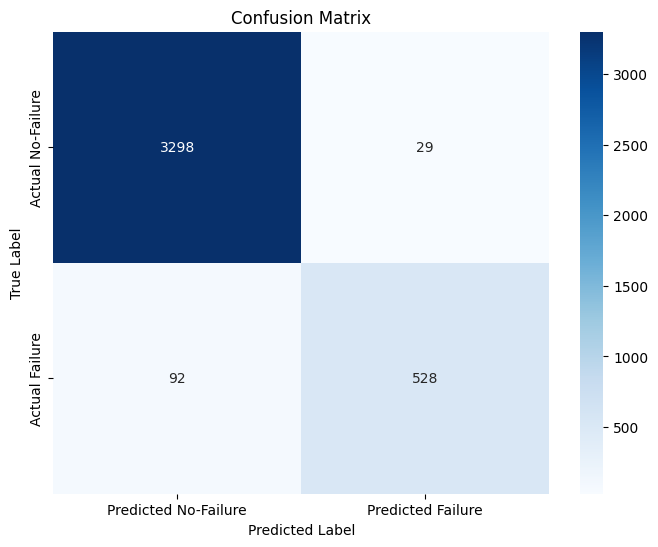

In [7]:
# Initialize and train the Random Forest model
# 'class_weight' is set to 'balanced' to handle imbalanced data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = rf_model.predict(X_val)

# Evaluate the model's performance
print("Model Evaluation on Validation Set:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\nClassification Report:")
# The classification report provides detailed metrics for each class
print(classification_report(y_val, y_pred, target_names=['No-Failure', 'Failure']))

# Visualize the confusion matrix to understand prediction errors
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No-Failure', 'Predicted Failure'], yticklabels=['Actual No-Failure', 'Actual Failure'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Model Evaluation & Results Analysis


This section presents the performance of our new **Random Forest Classifier** and analyzes its effectiveness as a predictive maintenance tool. Our goal is to assess how well the model can identify potential failures to serve as a reliable early warning system.

#### Summary of Key Performance Metrics

-   **Accuracy: 96.93%**
    While a high accuracy score is encouraging, it can be misleading in our imbalanced dataset (where failures are rare). Therefore, we will focus on more specialized metrics for a clearer picture.

-   **Precision: 0.95 (for the 'Failure' class)**
    This tells us that when our model predicts an engine is at risk of failure, it's correct **95% of the time**. This is a great result, as it significantly reduces **false alarms** and ensures we don't waste resources on unnecessary inspections.

-   **Recall: 0.85 (for the 'Failure' class)**
    This is the most critical metric for our project. A recall of **0.85** means our model successfully identifies **85% of all actual engine failures**. This is a strong indicator that the model is highly effective at catching impending faults, which is our primary goal.

-   **F1-Score: 0.90 (for the 'Failure' class)**
    The F1-Score provides a balanced view of both Precision and Recall. A score of **0.90** is excellent and shows that our model has a strong balance between avoiding false alarms and catching real failures.

---

#### Conclusion and Comparison

The **Random Forest Classifier** has proven to be a very strong **baseline model**. Unlike a regression model that predicts the Remaining Useful Life (RUL) as a number, our classification model acts as an effective **"go/no-go" early warning system**.

Its high **Recall (85%)** is particularly valuable for our use case, as it means we can confidently rely on this model to flag high-risk machines and prevent a significant majority of unplanned shutdowns. This makes it a great tool for a first-pass analysis before moving to more complex models.